# Conference Comparison Matrix
- create visualization of conference vs conference heatmap

## Setup - Men's Scores

In [112]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import datetime
from bs4 import BeautifulSoup
import requests
import re
# Load OffSetImage
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create Date and Time Strings for use in plots
# String of current Eastern Time Zone in HH:MM format (example: 15:00)
now = datetime.datetime.now()
time = now.strftime("%H:%M")

####### SET MANUAL TIME IF NEED BE #######
# time = '15:00'

anno_font_size_1 = '20'
anno_font_size_2 = '16'

# Date in MM/DD/YYYY Format
date = now.strftime("%m/%d/%Y")
# string of date with no slashes for use in file names
date_string = now.strftime("%m%d%Y")

### Set Default Plot Ratio and Size
set_fig_size = (8, 10) # Good Ratio for Reddit - Insta - mobile

# path top temp heatmap image folder
heatmap_path = os.path.join('..', 'TEMP', 'IMAGES', 'heatmaps')
if not os.path.exists(heatmap_path):
    os.makedirs(heatmap_path)

## Set the color map
color_map = 'coolwarm'
# Try other color options
# color_map = 'YlGnBu'  # Choose a color map for the heatmap
# color_map = 'viridis'
# color_map = 'plasma'
# color_map = 'inferno'
# color_map = 'magma'

##############################################


### Set the Color Pallete for all charts in workbook

In [113]:
# # Sequential colormaps (good for ordered data, low-to-high)
# color_map = 'Blues'
# color_map = 'BuGn'
# color_map = 'BuPu'
# color_map = 'GnBu'
# color_map = 'Greens'
# color_map = 'Greys'
# color_map = 'Oranges'
# color_map = 'OrRd'
# color_map = 'PuBu'
# color_map = 'PuBuGn'
# color_map = 'PuRd'
# color_map = 'Purples'
# color_map = 'RdPu'
# color_map = 'Reds'
# color_map = 'YlGn'
# color_map = 'YlGnBu'
# color_map = 'YlOrBr'
color_map = 'YlOrRd'

# # Matplotlib perceptually uniform sequential colormaps
# color_map = 'viridis'
# color_map = 'plasma'
# color_map = 'inferno'
# color_map = 'magma'
# color_map = 'cividis'

# # Seaborn palettes
# color_map = 'rocket'
# color_map = 'mako'
# color_map = 'flare'
# color_map = 'crest'
# color_map = 'chroma'



# ############## DIVERGING COLORMAPS
# # Diverging colormaps (good for data that has a meaningful midpoint, like zero)
# color_map = 'PiYG'
# color_map = 'PRGn'
# color_map = 'BrBG'
# color_map = 'PuOr'
# color_map = 'RdBu'
# color_map = 'RdGy'
# color_map = 'RdYlBu'
# color_map = 'RdYlGn'
# color_map = 'Spectral'
# color_map = 'coolwarm'
# color_map = 'bwr'
# color_map = 'seismic'


# ############# Cyclical Colormaps:
# # Cyclical colormaps (useful for data that wraps around cyclically)
# color_map = 'twilight'
# color_map = 'twilight_shifted'
# color_map = 'hsv'



# ############### Qualitative colormaps (best for categorical data)
# color_map = 'tab10'
# color_map = 'tab20'
# color_map = 'tab20b'
# color_map = 'tab20c'
# color_map = 'Set1'
# color_map = 'Set2'
# color_map = 'Set3'
# color_map = 'Pastel1'
# color_map = 'Pastel2'
# color_map = 'Paired'
# color_map = 'Accent'
# color_map = 'Dark2'


############# Miscellaneous colormaps
# color_map = 'flag'
# color_map = 'prism'
# color_map = 'ocean'
# color_map = 'gist_earth'
# color_map = 'terrain'
# color_map = 'rainbow'
# color_map = 'jet'  # (deprecated but still commonly used)
# color_map = 'nipy_spectral'
# color_map = 'gist_ncar'


### Get Current Men's Results Table form CHN

In [114]:
### USE Results Scraper code from other notebook to get up to date data
## Functions
### Parse the current season schedule / results page
############ USE WEB SCRAPING TO GET RESULTS TABLE ############
current_year_url = 'https://www.collegehockeynews.com/schedules/?season=20242025'

def parse_current_season(url):
        # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the page with BeautifulSoup
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                # Remove any hyphens from the team name
                home_team = home_team.replace('-', ' ')
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row
    return data

## call the function
data = parse_current_season(current_year_url)


# Create a dataframe from the list

columns = ['Date', 'Conference', 'Game_Notes', 'Home_Team', 'Home_Team_Link', 'Home_Score', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)
            
## Extract the day of the week from the date and save in new column
df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
# remove day of the week from date
# format data column as YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

### Create a new column for the game ID
## Game ID will be a combination of the date and abbreviated team names

# Loop to abbreviate the team names
for row in df.itertuples():
    home_team = row.Home_Team
    away_team = row.Away_Team
    home_team_abbr = home_team.split(' ')[-1]
    away_team_abbr = away_team.split(' ')[-1]
    # Remove any hyphens from the team name if there are any
    home_team_abbr = home_team_abbr.replace('-', ' ')
    away_team_abbr = away_team_abbr.replace('-', ' ')
    game_id = f'{row.Date}-{home_team_abbr}-{away_team_abbr}'
    df.loc[row.Index, 'Game_ID'] = game_id

# Create a new column for the game ID
df['Game_ID'] = df['Game_ID'].str.replace(',', '')

# Remove any hyphens from the team names if any
df['Home_Team'] = df['Home_Team'].str.replace('-', ' ')
df['Away_Team'] = df['Away_Team'].str.replace('-', ' ')

# Apply the function to the DataFrame
df['Game_ID'] = df.apply(lambda row: f'{row.Date}-{row.Home_Team}-{row.Away_Team}', axis=1)

## Filter out games that have not been played yet
df = df[df['Home_Score'] != '']

# Replace Nan values in metrics column with empty string
df['Metrics_Link'] = df['Metrics_Link'].fillna('')

# make sure Home_Score and Away_Score are integers
df['Home_Score'] = df['Home_Score'].astype(int)
df['Away_Score'] = df['Away_Score'].astype(int)

# Rename to schedule_df to put into next block
schedule_df = df

In [115]:

# # Load Schedult/results data and compare conferences
# path = os.path.join('..', 'data', 'schedule', 'Week 1 Scores.csv')
# # Load the data

# schedule_df = pd.read_csv(path)

# Define logo folder path
mens_logo_folder = os.path.join('..', 'images', 'logos', 'conference')
womens_logo_folder= os.path.join('..', 'images', 'logos', 'conference')
# filter out exhibition games
schedule_df = schedule_df[schedule_df['Conference'] != 'Exhibition']
# Clean up Team names (remove ' and periods)
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.replace("'", "").str.replace(".", "")
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.replace("'", "").str.replace(".", "")
# strip leading and trailing spaces
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.strip()
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.strip()
# Drop any rows containing a / or TBD
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('TBD')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('TBD')]

# Only Consider games designated Non-Conference
### This will miss a few special event / nueutral site games like the Ice Breaker
# schedule_df = schedule_df[schedule_df['Conference'] == 'Non-Conference']


# whitelist contains [Ice Breaker, ]


C:\Users\jbanc\AppData\Local\Temp\ipykernel_22200\1481343722.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule_df['Away_Team'] = schedule_df['Away_Team'].str.replace("'", "").str.replace(".", "")
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22200\1481343722.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule_df['Home_Team'] = schedule_df['Home_Team'].str.replace("'", "").str.replace(".", "")
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22200\1481343722.py:16: SettingWithCopyWarning: 
A v

## Men's D1

#### Backend

In [116]:
# Define the conferences
conference_teams = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']
}



In [117]:
# Function to get the conference of a team
def get_conference(team):
    for conference, teams in conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences - Stonehill and Long Island annonmaly
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

################# OUTPUT SCHEDULE_DF TO TEMP FOLDER FOR INSPECT
# schedule_df.to_csv(os.path.join('..', 'TEMP', 'schedule_df.csv'), index=False)
####################################################

# Rename to completed_games_df
completed_games_df = schedule_df

# Filter out only non-conference games
non_conference_games = schedule_df[schedule_df['Away_Conference'] != schedule_df['Home_Conference']]

# Create a list of unique conferences for indexing the matrix
conferences = list(set(non_conference_games['Away_Conference'].unique()).union(set(non_conference_games['Home_Conference'].unique())))

# Initialize an empty matrix with zeros
out_of_conference_matrix = pd.DataFrame(0, index=conferences, columns=conferences)

# Iterate over non-conference games to populate the matrix
for _, row in non_conference_games.iterrows():
    # Determine the winning and losing conference
    if row['Away_Score'] > row['Home_Score']:
        winning_conference = row['Away_Conference']
        losing_conference = row['Home_Conference']
    elif row['Home_Score'] > row['Away_Score']:
        winning_conference = row['Home_Conference']
        losing_conference = row['Away_Conference']
    else:
        # Skip ties for now
        continue

    # Increment the win count for the winning conference against the losing conference
    out_of_conference_matrix.loc[winning_conference, losing_conference] += 1

# Sort rows and columns alphabetically
out_of_conference_matrix = out_of_conference_matrix.sort_index(axis=0).sort_index(axis=1)


# Calculate wins by summing across rows (wins for each conference against others)
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate losses by summing across columns (losses against each conference)
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

### Find Out of Conference Ties, tally them and store as a seperate series to create the overall record
# Step 1: Calculate Ties for Each Conference
# Filter non-conference games and count ties
overall_out_of_conference_ties = pd.Series(0, index=conferences)

for _, row in non_conference_games.iterrows():
    if row['Away_Score'] == row['Home_Score']:
        # Increment ties for both the away and home conferences
        overall_out_of_conference_ties[row['Away_Conference']] += 1
        overall_out_of_conference_ties[row['Home_Conference']] += 1

## Calulate each conferences winning percentage
# Calculate the total games played by each conference
total_games_played = out_of_conference_matrix.sum(axis=1) + out_of_conference_matrix.sum(axis=0)
# add ties to total games played
total_games_played += overall_out_of_conference_ties

# Calculate the winning percentage for each conference
winning_percentage = overall_out_of_conference_wins / total_games_played
# Format the winning percentage to three decimal places
winning_percentage = winning_percentage.apply(lambda x: f'{x:.3f}')

# Step 2: Update Overall Record with Wins, Losses, and Ties
overall_record = (
    overall_out_of_conference_wins.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_losses.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_ties.astype(int).astype(str)
)

# print(overall_record)

###### TEST CODE FOR GOALS SCORED CONFGERENCE MATRIX

In [118]:
def get_conference(team):
    for conference, teams in conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

# Rename to completed_games_df
completed_games_df = schedule_df

# Filter out only non-conference games
non_conference_games = schedule_df[schedule_df['Away_Conference'] != schedule_df['Home_Conference']]

# Create a list of unique conferences for indexing the matrix
conferences = list(set(non_conference_games['Away_Conference'].unique()).union(set(non_conference_games['Home_Conference'].unique())))

# Initialize two matrices: one for total goals and one for game counts (to calculate averages)
goal_matrix = pd.DataFrame(0.0, index=conferences, columns=conferences)
game_count_matrix = pd.DataFrame(0, index=conferences, columns=conferences)

# Iterate over non-conference games to populate the matrices
for _, row in non_conference_games.iterrows():
    home_conference = row['Home_Conference']
    away_conference = row['Away_Conference']

    # Add the goals scored by the home and away teams
    goal_matrix.loc[home_conference, away_conference] += row['Home_Score']
    goal_matrix.loc[away_conference, home_conference] += row['Away_Score']

    # Increment the game count for both matchups
    game_count_matrix.loc[home_conference, away_conference] += 1
    game_count_matrix.loc[away_conference, home_conference] += 1

# Calculate the average goals by dividing the total goals by the number of games
average_goal_matrix = goal_matrix.div(game_count_matrix).fillna(0)

# Sort rows and columns alphabetically
average_goal_matrix = average_goal_matrix.sort_index(axis=0).sort_index(axis=1)

# Display the average goals matrix
print(average_goal_matrix)

              Atlantic   Big Ten      CCHA      ECAC  Hockey East  \
Atlantic      0.000000  1.400000  2.000000  2.722222     2.083333   
Big Ten       4.400000  0.000000  4.600000  3.400000     3.500000   
CCHA          3.000000  1.700000  0.000000  0.750000     3.000000   
ECAC          4.166667  1.800000  3.500000  0.000000     2.700000   
Hockey East   4.333333  2.750000  2.000000  3.500000     0.000000   
Independents  1.166667  2.125000  1.875000  2.800000     2.000000   
NCHC          3.666667  2.888889  2.904762  3.000000     3.000000   

              Independents      NCHC  
Atlantic          2.333333  2.833333  
Big Ten           3.000000  2.888889  
CCHA              2.375000  2.142857  
ECAC              2.600000  2.500000  
Hockey East       3.500000  2.769231  
Independents      0.000000  1.400000  
NCHC              3.400000  0.000000  


#### Average Goals Scored Heatmap

All logos successfully added.
All logos successfully added.


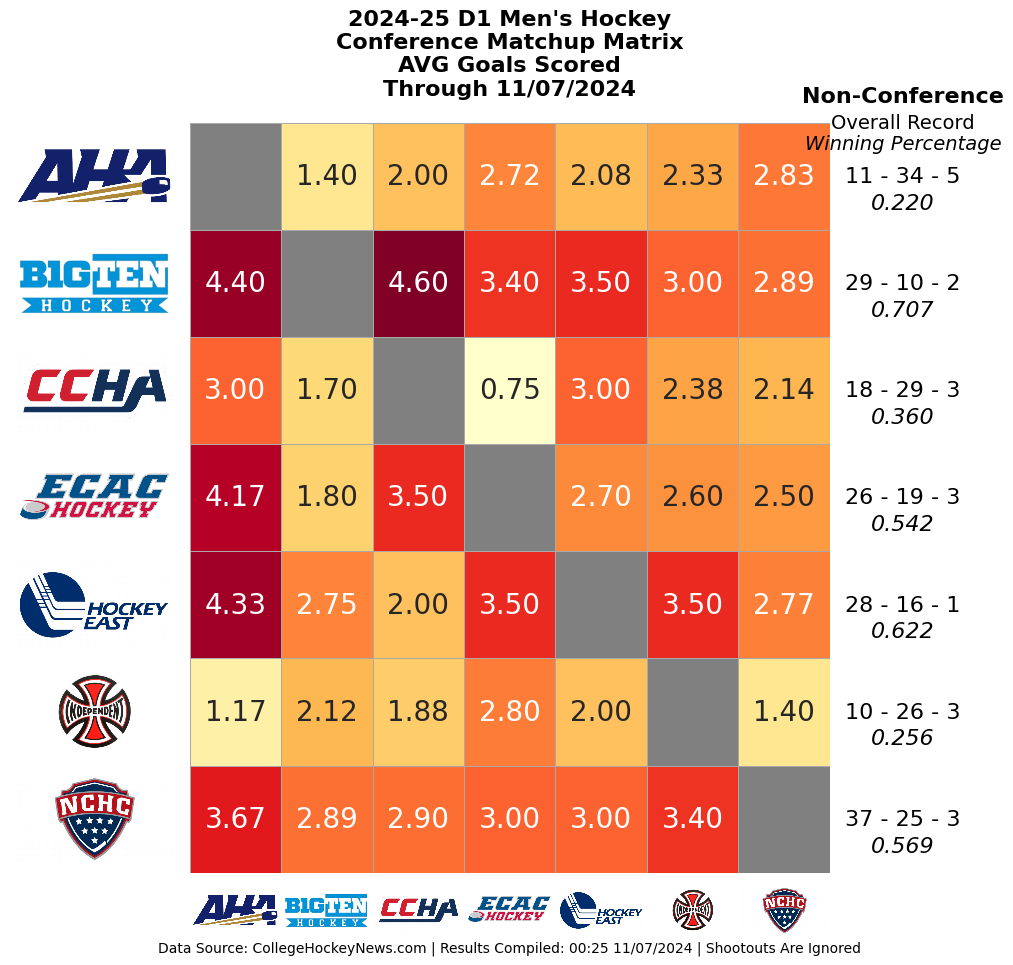

In [119]:
### Output Scoring average heatmap 



# Create the heatmap
plt.figure(figsize=(set_fig_size))  # Increase figure width for more space on the right side
# plt.figure(figsize=(8, 10))  # Increase figure width for more space on the right side

# Create a new mask that matches the shape of the average_goal_matrix
mask = average_goal_matrix == 0

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(average_goal_matrix,
                 annot=True, fmt='.2f',  # Add annotations with two decimal places
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": anno_font_size_1})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)  # Increase right to 0.95

# Add the overall record (win-loss-tie format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Adjust horizontal alignment and position for better visibility
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.5,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black')

# Add the winning percentage to the right side of the heatmap just under the overall record
for idx, label in enumerate(winning_percentage):
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.75,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black', fontstyle='italic')

# # Add label for the overall record column above the annotations
# ax.text(out_of_conference_matrix.shape[1] + 0.8, 0, "Non-Conference\nOverall Record",
#         va='center', ha='center', fontsize=14, color='black', weight='bold')

## Create new label - three lines Non-Conference (in bold), next line Overall Record, next line Winning Percentage (in italics)
ax.text(out_of_conference_matrix.shape[1] + 0.8, -0.25, "Non-Conference",
        va='center', ha='center', fontsize=16, color='black', weight='bold')
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0.0, "Overall Record",
        va='center', ha='center', fontsize=14, color='black')
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0.2, "Winning Percentage",
        va='center', ha='center', fontsize=14, color='black', fontstyle='italic')



# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}
# # Add conference logos as x-tick and y-tick labels
# def add_logo_to_axis(axis, axis_labels, is_xtick=True):
#     for idx, label in enumerate(axis_labels):
#         logo_path = os.path.join(mens_logo_folder, conference_logo_mapping[label])
#         if os.path.exists(logo_path):
#             img = plt.imread(logo_path)
#             zoom_level = 0.125 if is_xtick else 0.225  # Adjust zoom for x and y axis logos
#             imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
#             if is_xtick:
#                 ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
#                                    frameon=False, box_alignment=(0.5, 0.5),
#                                    xycoords=('data', 'axes fraction'))
#             else:
#                 ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
#                                    frameon=False, box_alignment=(0.5, 0.5),
#                                    xycoords=('axes fraction', 'data'))
#             axis.add_artist(ab)

# Refactored function to add debugging and reporting steps
def add_logo_to_axis(axis, axis_labels, mens_logo_folder, conference_logo_mapping, is_xtick=True):
    """
    Adds conference logos as tick labels on the specified axis.

    Parameters:
    - axis: The axis to modify (x-axis or y-axis).
    - axis_labels: List of conference names to use for logos.
    - mens_logo_folder: Folder path where logo images are stored.
    - conference_logo_mapping: Dictionary mapping conference names to logo filenames.
    - is_xtick: Boolean flag indicating if the logos are for x-tick (True) or y-tick (False) labels.
    """
    missing_logos = []

    for idx, label in enumerate(axis_labels):
        # Get the full path to the logo image
        logo_filename = conference_logo_mapping.get(label, "")
        logo_path = os.path.join(mens_logo_folder, logo_filename)

        # Debug: Report if the logo path exists or not
        if not os.path.exists(logo_path):
            print(f"Warning: Logo not found for {label} at {logo_path}")
            missing_logos.append(label)
            continue

        try:
            # Load the image and create the annotation box
            img = plt.imread(logo_path)
            zoom_level = 0.125 if is_xtick else 0.225  # Adjust zoom for x/y axis logos
            imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size

            # Adjust position to fit the x or y axis
            if is_xtick:
                ab = AnnotationBbox(
                    imagebox, (idx + 0.5, -0.05),  # Position below x-axis
                    frameon=False, box_alignment=(0.5, 0.5),
                    xycoords=('data', 'axes fraction')
                )
            else:
                ab = AnnotationBbox(
                    imagebox, (-0.15, idx + 0.5),  # Position left of y-axis
                    frameon=False, box_alignment=(0.5, 0.5),
                    xycoords=('axes fraction', 'data')
                )

            # Add the annotation to the axis
            axis.add_artist(ab)

        except Exception as e:
            # Report any errors during image loading or annotation
            print(f"Error adding logo for {label}: {e}")

    # Summary report of any missing logos
    if missing_logos:
        print(f"\nSummary: Logos missing for the following conferences: {', '.join(missing_logos)}")
    else:
        print("All logos successfully added.")


# # Add logos for x and y axes
# add_logo_to_axis(ax, out_of_conference_matrix.columns, is_xtick=True)
# add_logo_to_axis(ax, out_of_conference_matrix.index, is_xtick=False)

# Add logos for x and y axes
add_logo_to_axis(ax, out_of_conference_matrix.columns, mens_logo_folder, conference_logo_mapping, is_xtick=True)
add_logo_to_axis(ax, out_of_conference_matrix.index, mens_logo_folder, conference_logo_mapping, is_xtick=False)


# Add labels and titles outside of the logos
ax.set_ylabel('')
ax.set_xlabel('')
# Remove default x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Remove x and y tick marks
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

### NOT NESS, DON'T LIKE LOOK
# # Add Winning Conference label above y axis logos
# ax.text(out_of_conference_matrix.shape[1] - 8.2, 7.1, "Winning\nConference", va='center', ha='center', fontsize=12, weight='bold', color='black')

plt.title(f"2024-25 D1 Men's Hockey\nConference Matchup Matrix\nAVG Goals Scored\nThrough {date}", fontdict={'fontsize': 16}, weight='bold', pad=20)

# Add text for data annotation ( Data Source & Date) to bottom of image
plt.text(0.5, -0.1, f'Data Source: CollegeHockeyNews.com | Results Compiled: {time} {date} | Shootouts Are Ignored', ha='center', va='center', 
        fontsize=10, transform=ax.transAxes)

# Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()

# Save the plot
plt.savefig(os.path.join(heatmap_path, f'2024-25_D1_Mens_Hockey_Conference_Matchup_Matrix_AVG_Goals_Scored_{date_string}.png'), bbox_inches='tight')

# Show the plot
plt.show()



#### Output Viz

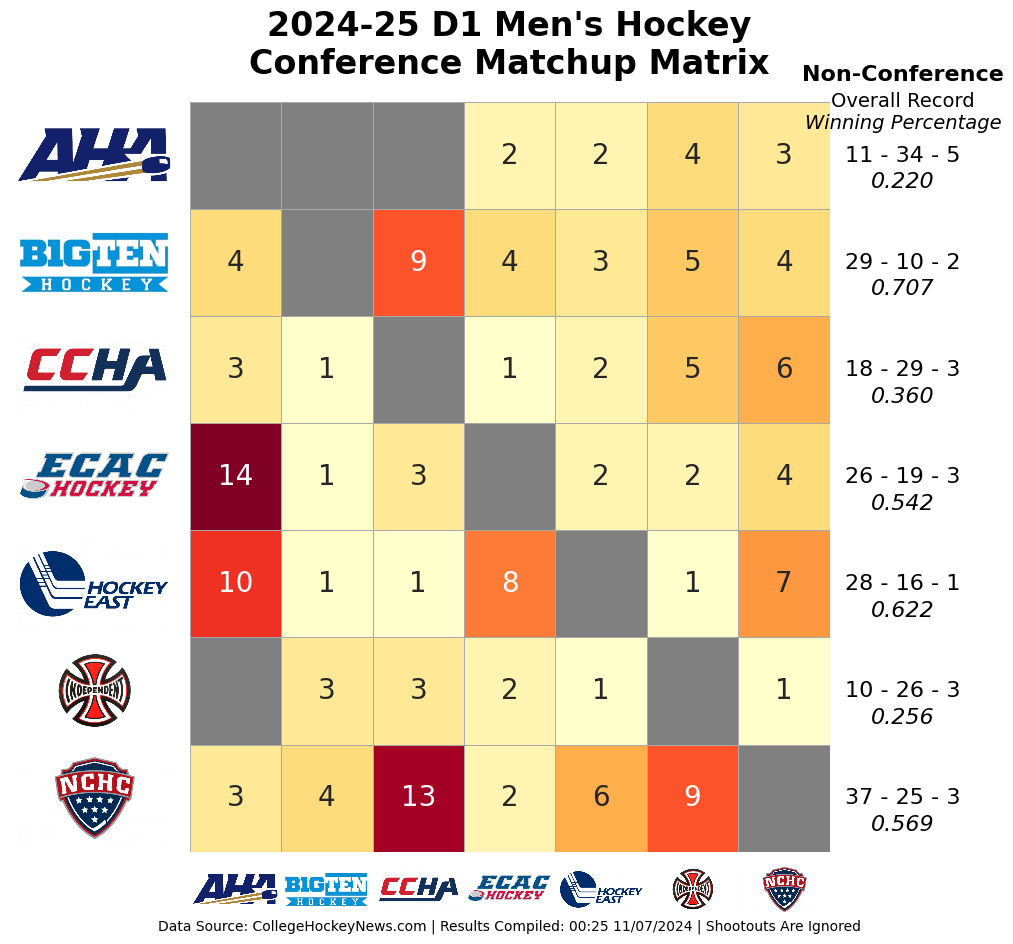

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os



# Create the heatmap
plt.figure(figsize=(set_fig_size))  # Use global figure size
# plt.figure(figsize=(8, 10))  # Increase figure width for more space on the right side

# Create a new mask that matches the shape of the out_of_conference_matrix
mask = out_of_conference_matrix == 0

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": anno_font_size_1})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)  # Increase right to 0.95

# Add the overall record (win-loss-tie format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Adjust horizontal alignment and position for better visibility
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.5,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black')

# Add the winning percentage to the right side of the heatmap just under the overall record
for idx, label in enumerate(winning_percentage):
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.75,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black', fontstyle='italic')

# 
## Create new label - three lines Non-Conference (in bold), next line Overall Record, next line Winning Percentage (in italics)
ax.text(out_of_conference_matrix.shape[1] + 0.8, -0.25, "Non-Conference",
        va='center', ha='center', fontsize=16, color='black', weight='bold')
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0.0, "Overall Record",
        va='center', ha='center', fontsize=14, color='black')
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0.2, "Winning Percentage",
        va='center', ha='center', fontsize=14, color='black', fontstyle='italic')
        
# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}
# Add conference logos as x-tick and y-tick labels
def add_logo_to_axis(axis, axis_labels, is_xtick=True):
    for idx, label in enumerate(axis_labels):
        logo_path = os.path.join(womens_logo_folder, conference_logo_mapping[label])
        if os.path.exists(logo_path):
            img = plt.imread(logo_path)
            zoom_level = 0.125 if is_xtick else 0.225  # Adjust zoom for x and y axis logos
            imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
            if is_xtick:
                ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('data', 'axes fraction'))
            else:
                ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('axes fraction', 'data'))
            axis.add_artist(ab)

# Add logos for x and y axes
add_logo_to_axis(ax, out_of_conference_matrix.columns, is_xtick=True)
add_logo_to_axis(ax, out_of_conference_matrix.index, is_xtick=False)

# Add labels and titles outside of the logos
ax.set_ylabel('')
ax.set_xlabel('')
# Remove default x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Remove x and y tick marks
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

### NOT NESS, DON'T LIKE LOOK
# # Add Winning Conference label above y axis logos
# ax.text(out_of_conference_matrix.shape[1] - 8.2, 7.1, "Winning\nConference", va='center', ha='center', fontsize=12, weight='bold', color='black')

plt.title("2024-25 D1 Men's Hockey\nConference Matchup Matrix", fontdict={'fontsize': 24}, weight='bold', pad=20)

# Add text for data annotation ( Data Source & Date) to bottom of image
plt.text(0.5, -0.1, f'Data Source: CollegeHockeyNews.com | Results Compiled: {time} {date} | Shootouts Are Ignored', ha='center', va='center', 
        fontsize=10, transform=ax.transAxes)

# Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()

# Save the plot to TEMP folder
plt.savefig(os.path.join(heatmap_path, f'2024-25_D1_Mens_Hockey_Conference_Matchup_Matrix_{date_string}.png'), bbox_inches='tight')


# Show the plot
plt.show()


#### Conference Win and Winning Percentage Line Charts

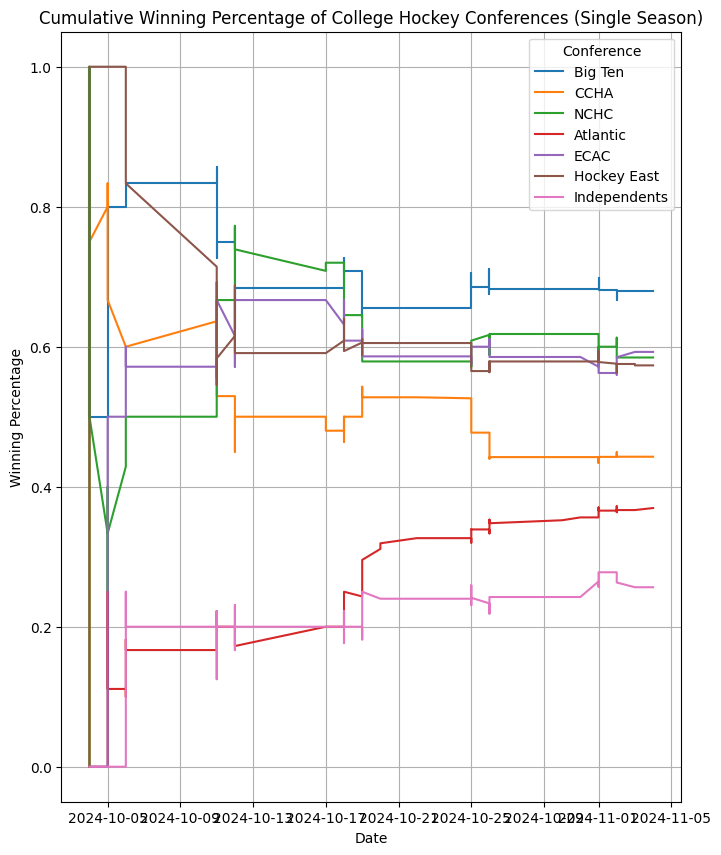

In [121]:
# Rename Results Table to df
df = completed_games_df

# Preprocessing: Determine the winner for each game
def determine_winner(row):
    if row['Home_Score'] > row['Away_Score']:
        return row['Home_Conference'], row['Away_Conference']
    else:
        return row['Away_Conference'], row['Home_Conference']

df[['Winning_Conference', 'Losing_Conference']] = df.apply(determine_winner, axis=1, result_type='expand')

# Convert 'Date' column to datetime format and sort the data by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Initialize dictionaries to track wins and games played over time
conference_stats = {}
for conference in pd.unique(df[['Home_Conference', 'Away_Conference']].values.ravel()):
    conference_stats[conference] = {'Wins': 0, 'Games': 0}

# Create a DataFrame to store cumulative winning percentage over time
winning_percentage_data = []

# Calculate cumulative wins and games played for each date and conference
for _, row in df.iterrows():
    winning_conference = row['Winning_Conference']
    losing_conference = row['Losing_Conference']
    game_date = row['Date']

    # Update wins and games played
    conference_stats[winning_conference]['Wins'] += 1
    conference_stats[winning_conference]['Games'] += 1
    conference_stats[losing_conference]['Games'] += 1

    # Record the cumulative winning percentage for all conferences at this date
    for conf, stats in conference_stats.items():
        wins, games = stats['Wins'], stats['Games']
        win_pct = wins / games if games > 0 else 0
        winning_percentage_data.append({'Date': game_date, 'Conference': conf, 'Win_Pct': win_pct})

# Convert the data into a DataFrame for plotting
win_pct_df = pd.DataFrame(winning_percentage_data)

# Plotting the line chart
plt.figure(figsize=set_fig_size)  # Set the figure size

# Plot a line for each conference
for conference in win_pct_df['Conference'].unique():
    conference_data = win_pct_df[win_pct_df['Conference'] == conference]
    plt.plot(conference_data['Date'], conference_data['Win_Pct'], label=conference)

# Chart settings
plt.title("Cumulative Winning Percentage of College Hockey Conferences (Single Season)")
plt.xlabel("Date")
plt.ylabel("Winning Percentage")
plt.legend(title="Conference")
plt.grid(True)

# Display the plot
plt.show()


#### Overall out of Conference Wins

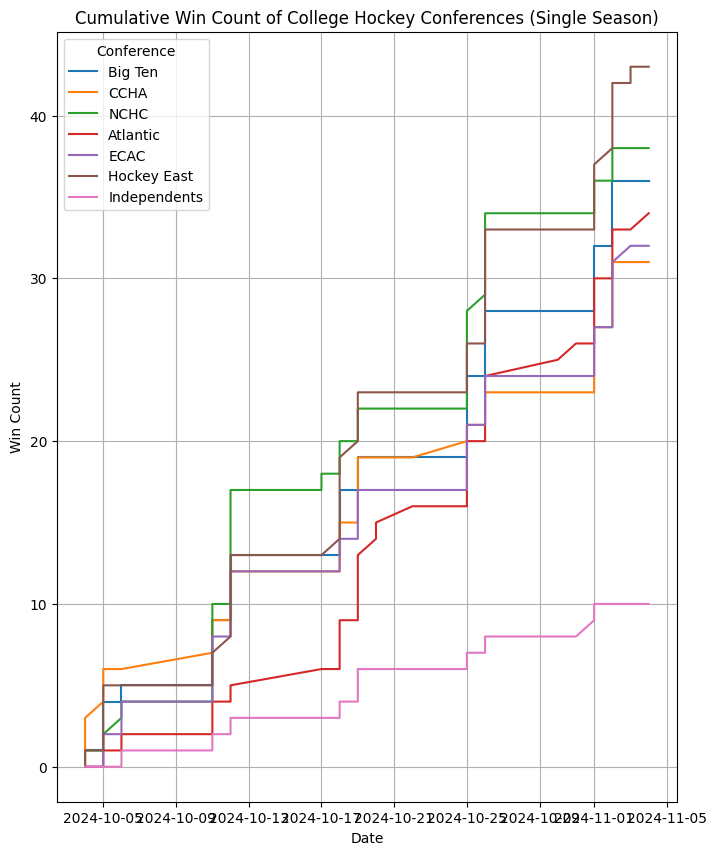

In [122]:
# Create a DataFrame to store cumulative win counts over time
win_count_data = []

# Reset the conference stats dictionary to track only win counts
conference_stats = {conf: {'Wins': 0} for conf in conference_stats}

# Calculate cumulative win counts for each date and conference
for _, row in df.iterrows():
    winning_conference = row['Winning_Conference']
    game_date = row['Date']

    # Update the win count for the winning conference
    conference_stats[winning_conference]['Wins'] += 1

    # Record the cumulative win counts for all conferences at this date
    for conf, stats in conference_stats.items():
        wins = stats['Wins']
        win_count_data.append({'Date': game_date, 'Conference': conf, 'Wins': wins})

# remane the dateframe 
win_count_df = pd.DataFrame(win_count_data)

# Plotting the line chart for win counts
plt.figure(figsize=set_fig_size)  # Set the figure size

# Plot a line for each conference
for conference in win_count_df['Conference'].unique():
    conference_data = win_count_df[win_count_df['Conference'] == conference]
    plt.plot(conference_data['Date'], conference_data['Wins'], label=conference)

# Chart settings
plt.title("Cumulative Win Count of College Hockey Conferences (Single Season)")
plt.xlabel("Date")
plt.ylabel("Win Count")
plt.legend(title="Conference")
plt.grid(True)

# Display the plot
plt.show()


##### ORIGNIAL NO LOGO MATRIX

In [123]:
# ###### ORINAL WORKING CODE #######

# # Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready
# color_map = 'YlGnBu'  # Choose a color map for the heatmap

# # Calculate the overall out-of-conference wins for each conference
# overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# # Calculate the total losses (opponent wins) for each conference
# overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

# # Prepare the win-loss record in "wins - losses" format
# overall_record = overall_out_of_conference_wins.astype(int).astype(str) + ' - ' + overall_out_of_conference_losses.astype(int).astype(str)

# # Mask 0s in the matrix
# mask = out_of_conference_matrix == 0

# # Create the heatmap
# plt.figure(figsize=(8, 10))

# # Plot the heatmap without zero values (masked)
# ax = sns.heatmap(out_of_conference_matrix,
#                  annot=True, fmt='d', 
#                  cmap=color_map, linewidths=.5, 
#                  cbar=False,  # Remove the color bar
#                  mask=mask,  # Mask the zero values
#                  annot_kws={"size": 16})  # Adjust annotation font size


# # Overlay only the zero cells with a gray color
# ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# # Add space on the right side to fit the overall record annotations
# plt.subplots_adjust(right=0.85)

# # Add the overall record (win-loss format) to the right side of the heatmap
# for idx, label in enumerate(overall_record):
#     # Position the text to the right of the heatmap
#     ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
#             label, va='center', ha='left', fontsize=12, color='black')

# # Add labels and titles
# ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
# ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
# plt.title("D1 Men's Hockey\nConference vs Conference Matrix", fontdict={'fontsize': 24})

# # Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()

# # Show the plot
# plt.show()

## Women's Plot 
- 

#### Get Women's Results Table from CHN

In [124]:
from bs4 import BeautifulSoup
import requests
import re

# url of CHN woman's results page - Only includes results from Oct 1 on - need to manually get and add September games
urls = ['https://www.collegehockeynews.com/women/schedule.php?date=20240920', 
        'https://www.collegehockeynews.com/women/schedule.php?date=20240927', 
        'https://www.collegehockeynews.com/women/schedule.php?season=20242025']

# url = 'https://www.collegehockeynews.com/women/schedule.php?season=20242025'

def get_game_data(url):
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the table with BeautifulSoup

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row

    return data

# Initialize an empty list to hold all the data
data = []

# loop through all the urls
for url in urls:
    data += get_game_data(url)
                


# Create a DataFrame
columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)

# # Clean Team names for ease of use (remove any dashes, ' or periods)
df['Away_Team'] = df['Away_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")
df['Home_Team'] = df['Home_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")

print('Original Length:', len(df))

# Drop any duplicate rows
df.drop_duplicates(inplace=True)

print('After Dropping Duplicates:', len(df))

# Drop Exhibition games
df = df[~df['Conference'].str.contains('Exhibition')]

print('After Dropping Exhibition Games:', len(df))

# Drop rows with / in either team name
df = df[~df['Away_Team'].str.contains('/')]
df = df[~df['Home_Team'].str.contains('/')]

print('After Dropping Teams with /:', len(df))
df.head(5)
# Rename to w_results_df
w_results_df = df
schedule_df = df

Original Length: 780
After Dropping Duplicates: 750
After Dropping Exhibition Games: 739
After Dropping Teams with /: 725


#### Back End

In [125]:
### Conference Membersip - Women's D1

w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']

w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']


w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']

w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

# Create dictionary of conferences and their teams

w_conference_teams = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}

In [126]:
# Function to get the conference of a team
def get_conference(team):
    for conference, teams in w_conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences - Stonehill and Long Island annonmaly
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

# Remove any games that haven't been played yet (no value in home or away score
schedule_df = schedule_df[(schedule_df['Home_Score'] != '') & (schedule_df['Away_Score'] != '')]


################# OUTPUT SCHEDULE_DF TO TEMP FOLDER FOR INSPECT
# schedule_df.to_csv(os.path.join('..', 'TEMP', 'schedule_df.csv'), index=False)
####################################################

# Rename to completed_games_df
completed_games_df = schedule_df

# Filter out only non-conference games
non_conference_games = completed_games_df[completed_games_df['Away_Conference'] != completed_games_df['Home_Conference']]

# Create a list of unique conferences for indexing the matrix
conferences = list(set(non_conference_games['Away_Conference'].unique()).union(set(non_conference_games['Home_Conference'].unique())))

# Initialize an empty matrix with zeros
out_of_conference_matrix = pd.DataFrame(0, index=conferences, columns=conferences)

# Iterate over non-conference games to populate the matrix
for _, row in non_conference_games.iterrows():
    # Determine the winning and losing conference
    if row['Away_Score'] > row['Home_Score']:
        winning_conference = row['Away_Conference']
        losing_conference = row['Home_Conference']
    elif row['Home_Score'] > row['Away_Score']:
        winning_conference = row['Home_Conference']
        losing_conference = row['Away_Conference']
    else:
        # Skip ties for now
        continue

    # Increment the win count for the winning conference against the losing conference
    out_of_conference_matrix.loc[winning_conference, losing_conference] += 1

# Sort rows and columns alphabetically
out_of_conference_matrix = out_of_conference_matrix.sort_index(axis=0).sort_index(axis=1)


# Calculate wins by summing across rows (wins for each conference against others)
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate losses by summing across columns (losses against each conference)
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

### Find Out of Conference Ties, tally them and store as a seperate series to create the overall record
# Step 1: Calculate Ties for Each Conference
# Filter non-conference games and count ties
overall_out_of_conference_ties = pd.Series(0, index=conferences)

for _, row in non_conference_games.iterrows():
    if row['Away_Score'] == row['Home_Score']:
        # Increment ties for both the away and home conferences
        overall_out_of_conference_ties[row['Away_Conference']] += 1
        overall_out_of_conference_ties[row['Home_Conference']] += 1

## Calulate each conferences winning percentage
# Calculate the total games played by each conference
total_games_played = out_of_conference_matrix.sum(axis=1) + out_of_conference_matrix.sum(axis=0)
# add ties to total games played
total_games_played += overall_out_of_conference_ties

# Calculate the winning percentage for each conference
winning_percentage = overall_out_of_conference_wins / total_games_played
# Format the winning percentage to three decimal places
winning_percentage = winning_percentage.apply(lambda x: f'{x:.3f}')


# Step 2: Update Overall Record with Wins, Losses, and Ties
overall_record = (
    overall_out_of_conference_wins.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_losses.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_ties.astype(int).astype(str)
)

print(overall_record)

Atlantic       21 - 31 - 4
ECAC           38 - 23 - 3
Hockey East    20 - 20 - 1
NewHA           1 - 26 - 1
WCHA            23 - 3 - 1
dtype: object


In [127]:
# print(completed_games_df.head())
# print(non_conference_games.head())
print(non_conference_games[['Away_Conference', 'Home_Conference', 'Home_Score', 'Away_Score']].info())


<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 7 to 218
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Away_Conference  108 non-null    object
 1   Home_Conference  108 non-null    object
 2   Home_Score       108 non-null    object
 3   Away_Score       108 non-null    object
dtypes: object(4)
memory usage: 4.2+ KB
None


In [128]:
### Create matrix of average goals scored per game like the men's matrix
## Use the completed_games_df to calculate the average goals scored per game for each conference matchup
# Filter out only non-conference games
non_conference_games = completed_games_df[completed_games_df['Away_Conference'] != completed_games_df['Home_Conference']]

non_conference_games['Home_Score'] = pd.to_numeric(non_conference_games['Home_Score'], errors='coerce')
non_conference_games['Away_Score'] = pd.to_numeric(non_conference_games['Away_Score'], errors='coerce')

# Create a list of unique conferences for indexing the matrix
conferences = sorted(set(non_conference_games['Away_Conference']).union(set(non_conference_games['Home_Conference'])))

# conferences = list(set(non_conference_games['Away_Conference'].unique()).union(set(non_conference_games['Home_Conference'].unique())))
# Initialize two matrices: one for total goals and one for game counts (to calculate averages)
goal_matrix = pd.DataFrame(0.0, index=conferences, columns=conferences)
game_count_matrix = pd.DataFrame(0, index=conferences, columns=conferences)

# Iterate over non-conference games to populate the matrices
for _, row in non_conference_games.iterrows():
    home_conference = row['Home_Conference']
    away_conference = row['Away_Conference']

    # Add the goals scored by the home and away teams
    goal_matrix.loc[home_conference, away_conference] += row['Home_Score']
    goal_matrix.loc[away_conference, home_conference] += row['Away_Score']

    # Increment the game count for both matchups
    game_count_matrix.loc[home_conference, away_conference] += 1
    game_count_matrix.loc[away_conference, home_conference] += 1

# Calculate the average goals by dividing the total goals by the number of games
average_goal_matrix = goal_matrix.div(game_count_matrix).fillna(0)

# Sort rows and columns alphabetically
average_goal_matrix = average_goal_matrix.sort_index(axis=0).sort_index(axis=1)

# Display the average goals matrix
print(average_goal_matrix)



             Atlantic      ECAC  Hockey East     NewHA      WCHA
Atlantic     0.000000  1.766667     1.750000  5.714286  1.545455
ECAC         2.966667  0.000000     3.000000  7.222222  2.600000
Hockey East  3.125000  1.400000     0.000000  4.857143  1.000000
NewHA        0.428571  0.777778     0.714286  0.000000  0.400000
WCHA         4.636364  4.000000     4.500000  6.000000  0.000000


C:\Users\jbanc\AppData\Local\Temp\ipykernel_22200\3329640394.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_conference_games['Home_Score'] = pd.to_numeric(non_conference_games['Home_Score'], errors='coerce')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22200\3329640394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_conference_games['Away_Score'] = pd.to_numeric(non_conference_games['Away_Score'], errors='coerce')


In [129]:
## Save results table to csv for inspection 
# w_results_df.to_csv('../TEMP/w_results_df.csv')

#### Women's Scoring Average Plot

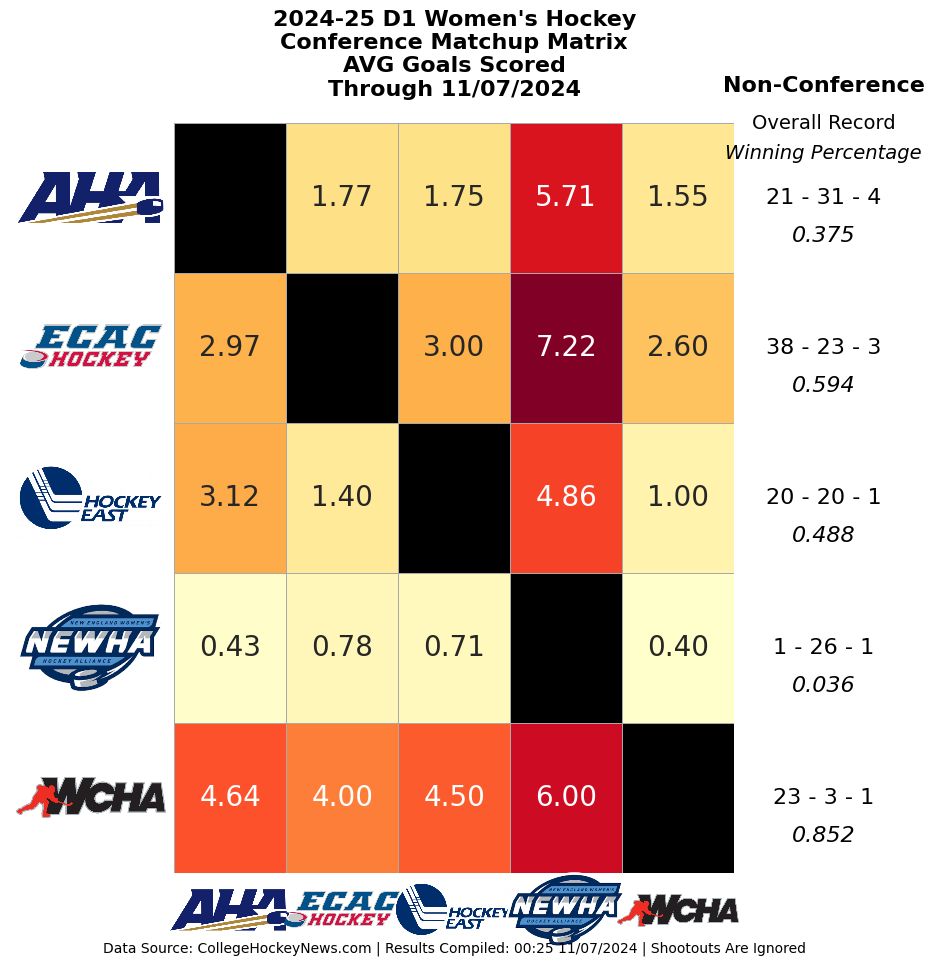

In [130]:
### Output Scoring average heatmap 



# Create the heatmap
plt.figure(figsize=(set_fig_size))  # Increase figure width for more space on the right side
# plt.figure(figsize=(8, 10))  # Increase figure width for more space on the right side

# Create a new mask that matches the shape of the average_goal_matrix
mask = average_goal_matrix == 0

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(average_goal_matrix,
                 annot=True, fmt='.2f',  # Add annotations with two decimal places
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": anno_font_size_1})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['black']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

# Add the overall record (win-loss-tie format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Adjust horizontal alignment and position for better visibility
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.5,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black')

# Add the winning percentage to the right side of the heatmap just under the overall record
for idx, label in enumerate(winning_percentage):
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.75,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black', fontstyle='italic')

# # Add label for the overall record column above the annotations
# ax.text(out_of_conference_matrix.shape[1] + 0.8, 0, "Non-Conference\nOverall Record",
#         va='center', ha='center', fontsize=14, color='black', weight='bold')

## Create new label - three lines Non-Conference (in bold), next line Overall Record, next line Winning Percentage (in italics)
ax.text(out_of_conference_matrix.shape[1] + 0.8, -0.25, "Non-Conference",
        va='center', ha='center', fontsize=16, color='black', weight='bold')
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0.0, "Overall Record",
        va='center', ha='center', fontsize=14, color='black')
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0.2, "Winning Percentage",
        va='center', ha='center', fontsize=14, color='black', fontstyle='italic')



# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}
# # Add conference logos as x-tick and y-tick labels
# def add_logo_to_axis(axis, axis_labels, is_xtick=True):
#     for idx, label in enumerate(axis_labels):
#         logo_path = os.path.join(mens_logo_folder, conference_logo_mapping[label])
#         if os.path.exists(logo_path):
#             img = plt.imread(logo_path)
#             zoom_level = 0.125 if is_xtick else 0.225  # Adjust zoom for x and y axis logos
#             imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
#             if is_xtick:
#                 ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
#                                    frameon=False, box_alignment=(0.5, 0.5),
#                                    xycoords=('data', 'axes fraction'))
#             else:
#                 ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
#                                    frameon=False, box_alignment=(0.5, 0.5),
#                                    xycoords=('axes fraction', 'data'))
#             axis.add_artist(ab)

mens_logo_folder = womens_logo_folder
# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}


# Add conference logos as x-tick and y-tick labels
def add_logo_to_axis(axis, axis_labels, is_xtick=True):
    for idx, label in enumerate(axis_labels):
        logo_path = os.path.join(mens_logo_folder, conference_logo_mapping[label])
        if os.path.exists(logo_path):
            img = plt.imread(logo_path)
            zoom_level = 0.175 if is_xtick else 0.215  # Adjust zoom for x and y axis logos
            imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
            if is_xtick:
                ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('data', 'axes fraction'))
            else:
                ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('axes fraction', 'data'))
            axis.add_artist(ab)
            
# # Refactored function to add debugging and reporting steps
# def add_logo_to_axis(axis, axis_labels, mens_logo_folder, conference_logo_mapping, is_xtick=True):
#     """
#     Adds conference logos as tick labels on the specified axis.

#     Parameters:
#     - axis: The axis to modify (x-axis or y-axis).
#     - axis_labels: List of conference names to use for logos.
#     - mens_logo_folder: Folder path where logo images are stored.
#     - conference_logo_mapping: Dictionary mapping conference names to logo filenames.
#     - is_xtick: Boolean flag indicating if the logos are for x-tick (True) or y-tick (False) labels.
#     """
#     missing_logos = []

#     for idx, label in enumerate(axis_labels):
#         # Get the full path to the logo image
#         logo_filename = conference_logo_mapping.get(label, "")
#         logo_path = os.path.join(womens_logo_folder, logo_filename)

#         # Debug: Report if the logo path exists or not
#         if not os.path.exists(logo_path):
#             print(f"Warning: Logo not found for {label} at {logo_path}")
#             missing_logos.append(label)
#             continue

#         try:
#             # Load the image and create the annotation box
#             img = plt.imread(logo_path)
#             zoom_level = 0.125 if is_xtick else 0.225  # Adjust zoom for x/y axis logos
#             imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size

#             # Adjust position to fit the x or y axis
#             if is_xtick:
#                 ab = AnnotationBbox(
#                     imagebox, (idx + 0.5, -0.05),  # Position below x-axis
#                     frameon=False, box_alignment=(0.5, 0.5),
#                     xycoords=('data', 'axes fraction')
#                 )
#             else:
#                 ab = AnnotationBbox(
#                     imagebox, (-0.15, idx + 0.5),  # Position left of y-axis
#                     frameon=False, box_alignment=(0.5, 0.5),
#                     xycoords=('axes fraction', 'data')
#                 )

#             # Add the annotation to the axis
#             axis.add_artist(ab)

#         except Exception as e:
#             # Report any errors during image loading or annotation
#             print(f"Error adding logo for {label}: {e}")

#     # Summary report of any missing logos
#     if missing_logos:
#         print(f"\nSummary: Logos missing for the following conferences: {', '.join(missing_logos)}")
#     else:
#         print("All logos successfully added.")




# Add logos for x and y axes
add_logo_to_axis(ax, out_of_conference_matrix.columns, is_xtick=True)
add_logo_to_axis(ax, out_of_conference_matrix.index, is_xtick=False)

# Add labels and titles outside of the logos
ax.set_ylabel('')
ax.set_xlabel('')
# Remove default x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Remove x and y tick marks
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

### NOT NESS, DON'T LIKE LOOK
# # Add Winning Conference label above y axis logos
# ax.text(out_of_conference_matrix.shape[1] - 8.2, 7.1, "Winning\nConference", va='center', ha='center', fontsize=12, weight='bold', color='black')

plt.title(f"2024-25 D1 Women's Hockey\nConference Matchup Matrix\nAVG Goals Scored\nThrough {date}", fontdict={'fontsize': 16}, weight='bold', pad=20)

# Add text for data annotation ( Data Source & Date) to bottom of image
plt.text(0.5, -0.1, f'Data Source: CollegeHockeyNews.com | Results Compiled: {time} {date} | Shootouts Are Ignored', ha='center', va='center', 
        fontsize=10, transform=ax.transAxes)

# Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()

# Save the plot
plt.savefig(os.path.join(heatmap_path, f'2024-25_D1_Womens_Hockey_Conference_Matchup_Matrix_AVG_Goals_Scored_{date_string}.png'), bbox_inches='tight')

# Show the plot
plt.show()



#### Output Women's D1 Plot

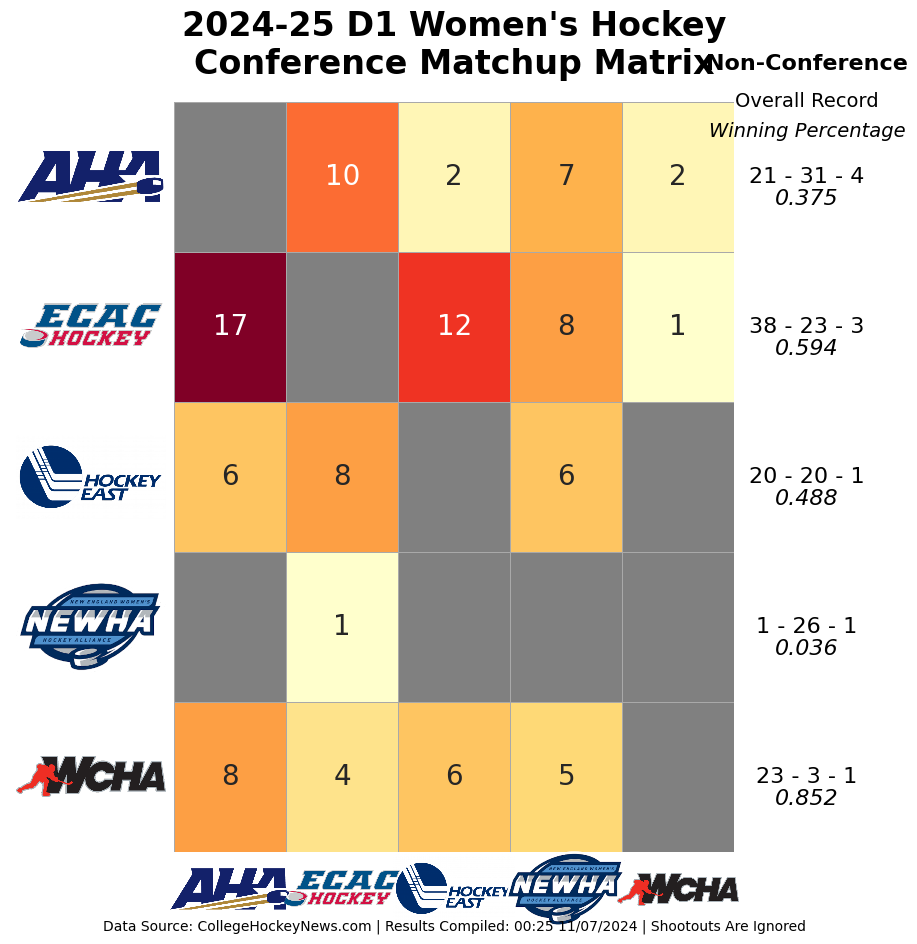

In [131]:
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os



# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=set_fig_size)  # Increase figure width for more space on the right side
# plt.figure(figsize=(10, 10))  # Increase figure width for more space on the right side

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": anno_font_size_1})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

# Add the overall record (win-loss-tie format) to the right side of the heatmap as well as the win percentage
for idx, label in enumerate(overall_record):
    # Adjust horizontal alignment and position for better visibility
    ax.text(out_of_conference_matrix.shape[1] + 0.65, idx + 0.5,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black')

# Add the winning percentage to the right side of the heatmap just under the overall record
for idx, label in enumerate(winning_percentage):
    ax.text(out_of_conference_matrix.shape[1] + 0.65, idx + 0.65,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black', fontstyle='italic')
            

# # Add label for the overall record column above the annotations
# ax.text(out_of_conference_matrix.shape[1] + 0.65, 0, "vs Other\nConferences",
#         va='center', ha='center', fontsize=14, color='black', weight='bold')

## Create new label - three lines Non-Conference (in bold), next line Overall Record, next line Winning Percentage (in italics)
ax.text(out_of_conference_matrix.shape[1] + 0.65, -0.25, "Non-Conference",
        va='center', ha='center', fontsize=16, color='black', weight='bold')
ax.text(out_of_conference_matrix.shape[1] + 0.65, 0.0, "Overall Record",
        va='center', ha='center', fontsize=14, color='black')
ax.text(out_of_conference_matrix.shape[1] + 0.65, 0.2, "Winning Percentage",
        va='center', ha='center', fontsize=14, color='black', fontstyle='italic')

# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}


# Add conference logos as x-tick and y-tick labels
def add_logo_to_axis(axis, axis_labels, is_xtick=True):
    for idx, label in enumerate(axis_labels):
        logo_path = os.path.join(mens_logo_folder, conference_logo_mapping[label])
        if os.path.exists(logo_path):
            img = plt.imread(logo_path)
            zoom_level = 0.175 if is_xtick else 0.215  # Adjust zoom for x and y axis logos
            imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
            if is_xtick:
                ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('data', 'axes fraction'))
            else:
                ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('axes fraction', 'data'))
            axis.add_artist(ab)



# Add logos for x and y axes
add_logo_to_axis(ax, out_of_conference_matrix.columns, is_xtick=True)
add_logo_to_axis(ax, out_of_conference_matrix.index, is_xtick=False)

# Add labels and titles outside of the logos
# ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16}, labelpad=50)
# ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16}, labelpad=115)
ax.set_ylabel('')
ax.set_xlabel('')
# Remove default x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Remove x and y tick marks
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)


plt.title("2024-25 D1 Women's Hockey\nConference Matchup Matrix", fontdict={'fontsize': 24}, weight='bold', pad=20)

plt.text(0.5, -0.1, f'Data Source: CollegeHockeyNews.com | Results Compiled: {time} {date} | Shootouts Are Ignored', ha='center', va='center', 
        fontsize=10, transform=ax.transAxes)


# Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()
# Invert the x-axis to match the conference hierarchy
# plt.gca().invert_xaxis()

# Save to TEMP FOLDER & Replace if needed
plt.savefig(os.path.join(heatmap_path, f'Conference_Matchup_Matrix_Womens_{date_string}.png'), bbox_inches='tight', dpi=300)

# Show the plot
plt.show()




#### Wins & Winning Pecentage Line Charts

In [132]:
schedule_df.head()

,Date,Conference,Game_Notes,Away_Team,Away_Team_Link,Away_Score,Home_Team,Home_Team_Link,Home_Score,OT,Box_Link,Metrics_Link,Away_Conference,Home_Conference
6,"Saturday, September 21, 2024",WCHA,,Minnesota Duluth,/women/team/Minnesota-Duluth/36,2,Ohio State,/women/team/Ohio-State/44,1,,/box/final/20240921/mnd/osu/w,None,WCHA,WCHA
7,"Saturday, September 21, 2024",Non-Conference,,St Cloud State,/women/team/St-Cloud-State/52,4,Lindenwood,/women/team/Lindenwood/433,0,,/box/final/20240921/stc/lin/w,None,WCHA,Atlantic
8,"Sunday, September 22, 2024",Non-Conference,,St Cloud State,/women/team/St-Cloud-State/52,6,Lindenwood,/women/team/Lindenwood/433,2,,/box/final/20240922/stc/lin/w,None,WCHA,Atlantic
12,"Sunday, September 22, 2024",WCHA,,Minnesota Duluth,/women/team/Minnesota-Duluth/36,4,Ohio State,/women/team/Ohio-State/44,3,,/box/final/20240922/mnd/osu/w,None,WCHA,WCHA
13,"Thursday, September 26, 2024",Non-Conference,,Northeastern,/women/team/Northeastern/41,3,Penn State,/women/team/Penn-State/60,1,,/box/final/20240926/noe/psu/w,None,Hockey East,Atlantic


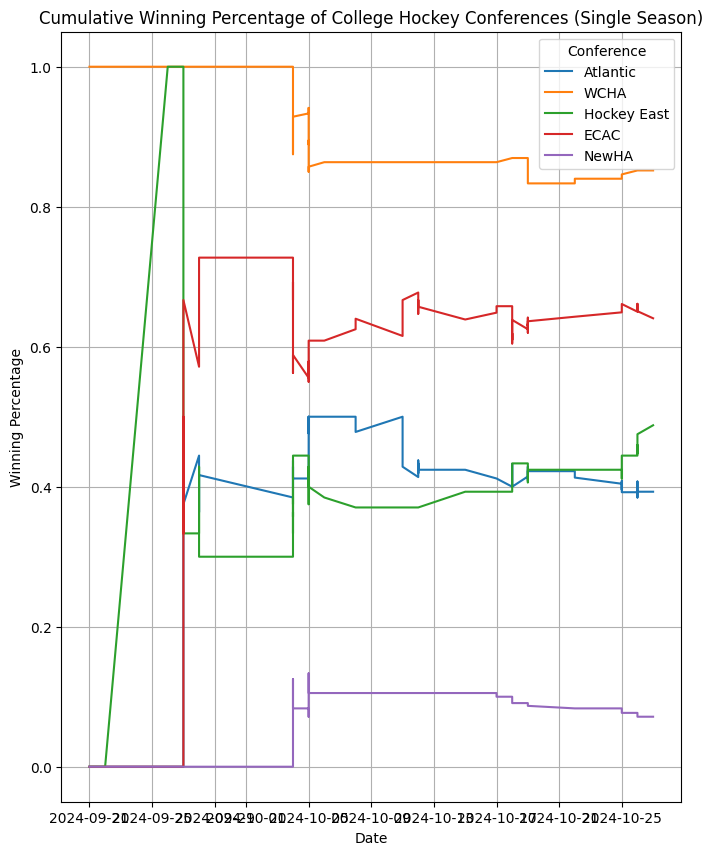

In [133]:
import matplotlib.pyplot as plt

# Rename Results Table to df
df = schedule_df
# Drop games that haven't been played yet
df = df.dropna(subset=['Home_Score', 'Away_Score'])
# Drop in conference games
df = df[df['Home_Conference'] != df['Away_Conference']]

# Preprocessing: Determine the winner for each game
def determine_winner(row):
    if row['Home_Score'] > row['Away_Score']:
        return row['Home_Conference'], row['Away_Conference']
    else:
        return row['Away_Conference'], row['Home_Conference']

df[['Winning_Conference', 'Losing_Conference']] = df.apply(determine_winner, axis=1, result_type='expand')

# Convert 'Date' column to datetime format and sort the data by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Initialize dictionaries to track wins and games played over time
conference_stats = {}
for conference in pd.unique(df[['Home_Conference', 'Away_Conference']].values.ravel()):
    conference_stats[conference] = {'Wins': 0, 'Games': 0}

# Create a DataFrame to store cumulative winning percentage over time
winning_percentage_data = []

# Calculate cumulative wins and games played for each date and conference
for _, row in df.iterrows():
    winning_conference = row['Winning_Conference']
    losing_conference = row['Losing_Conference']
    game_date = row['Date']

    # Update wins and games played
    conference_stats[winning_conference]['Wins'] += 1
    conference_stats[winning_conference]['Games'] += 1
    conference_stats[losing_conference]['Games'] += 1

    # Record the cumulative winning percentage for all conferences at this date
    for conf, stats in conference_stats.items():
        wins, games = stats['Wins'], stats['Games']
        win_pct = wins / games if games > 0 else 0
        winning_percentage_data.append({'Date': game_date, 'Conference': conf, 'Win_Pct': win_pct})

# Convert the data into a DataFrame for plotting
win_pct_df = pd.DataFrame(winning_percentage_data)

# Plotting the line chart
plt.figure(figsize=set_fig_size)  # Set the figure size 

# Plot a line for each conference
for conference in win_pct_df['Conference'].unique():
    conference_data = win_pct_df[win_pct_df['Conference'] == conference]
    plt.plot(conference_data['Date'], conference_data['Win_Pct'], label=conference)

# Chart settings
plt.title("Cumulative Winning Percentage of College Hockey Conferences (Single Season)")
plt.xlabel("Date")
plt.ylabel("Winning Percentage")
plt.legend(title="Conference")
plt.grid(True)

# Display the plot
plt.show()


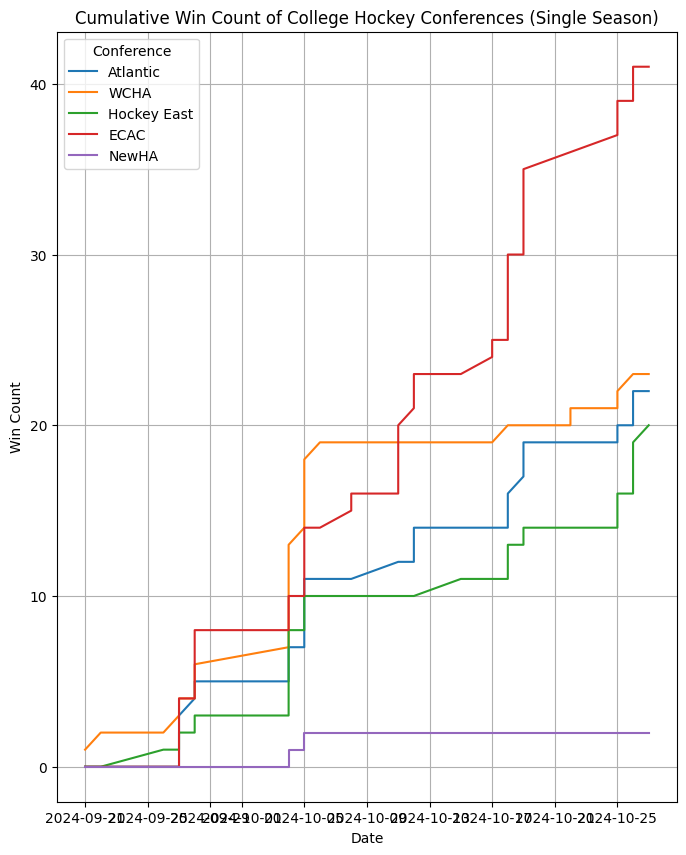

In [134]:
# Create a DataFrame to store cumulative win counts over time
win_count_data = []

# Reset the conference stats dictionary to track only win counts
conference_stats = {conf: {'Wins': 0} for conf in conference_stats}

# Calculate cumulative win counts for each date and conference
for _, row in df.iterrows():
    winning_conference = row['Winning_Conference']
    game_date = row['Date']

    # Update the win count for the winning conference
    conference_stats[winning_conference]['Wins'] += 1

    # Record the cumulative win counts for all conferences at this date
    for conf, stats in conference_stats.items():
        wins = stats['Wins']
        win_count_data.append({'Date': game_date, 'Conference': conf, 'Wins': wins})

# Convert the data into a DataFrame for plotting
win_count_df = pd.DataFrame(win_count_data)

# Plotting the line chart for win counts
plt.figure(figsize=set_fig_size)  # Set the figure size

# Plot a line for each conference
for conference in win_count_df['Conference'].unique():
    conference_data = win_count_df[win_count_df['Conference'] == conference]
    plt.plot(conference_data['Date'], conference_data['Wins'], label=conference)

# Chart settings
plt.title("Cumulative Win Count of College Hockey Conferences (Single Season)")
plt.xlabel("Date")
plt.ylabel("Win Count")
plt.legend(title="Conference")
plt.grid(True)

# Display the plot
plt.show()
